In [1]:
from datasets import load_dataset

#Load the DBpedia 14 dataset
dataset=load_dataset("dbpedia_14")

print(dataset)


d:\DataScience\ProjectsPractice\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 560000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 70000
    })
})


In [2]:
#Show first sample in dataset
print("\n First Sample in dataset:\n",dataset['train'][0])


 First Sample in dataset:
 {'label': 0, 'title': 'E. D. Abbott Ltd', 'content': ' Abbott of Farnham E D Abbott Limited was a British coachbuilding business based in Farnham Surrey trading under that name from 1929. A major part of their output was under sub-contract to motor vehicle manufacturers. Their business closed in 1972.'}


In [3]:
#show column names and label types
print("\n Features:\n",dataset['train'].features)


 Features:
 {'label': ClassLabel(names=['Company', 'EducationalInstitution', 'Artist', 'Athlete', 'OfficeHolder', 'MeanOfTransportation', 'Building', 'NaturalPlace', 'Village', 'Animal', 'Plant', 'Album', 'Film', 'WrittenWork']), 'title': Value('string'), 'content': Value('string')}


In [4]:
#Hugging face stores labels as integers(0 to 13), so we need the mapping to class names
label_names=dataset['train'].features['label'].names
print("Label names:")
for idx,label in enumerate(label_names):
    print(f"{idx}: {label}")

Label names:
0: Company
1: EducationalInstitution
2: Artist
3: Athlete
4: OfficeHolder
5: MeanOfTransportation
6: Building
7: NaturalPlace
8: Village
9: Animal
10: Plant
11: Album
12: Film
13: WrittenWork


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
#convert to pandas Dataframe
df_train=pd.DataFrame(dataset['train'])

#map integer labels to text
df_train['label_name']=df_train['label'].apply(lambda x: label_names[x])

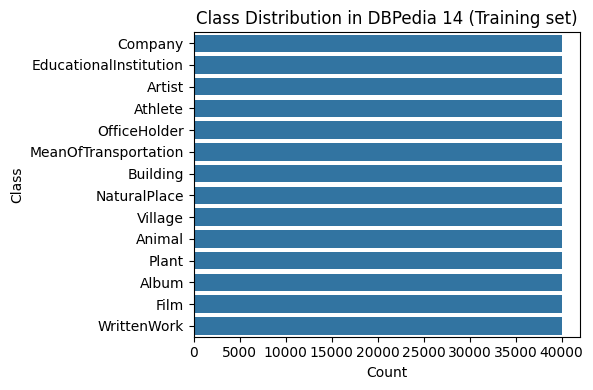

In [7]:
#plot
plt.figure(figsize=(6,4))
sns.countplot(data=df_train,y='label_name',order=df_train['label_name'].value_counts().index)
plt.title("Class Distribution in DBPedia 14 (Training set)")
plt.xlabel("Count")
plt.ylabel("Class")
plt.tight_layout()
plt.show()

In [8]:
df_train['label_name'].value_counts()

label_name
Company                   40000
EducationalInstitution    40000
Artist                    40000
Athlete                   40000
OfficeHolder              40000
MeanOfTransportation      40000
Building                  40000
NaturalPlace              40000
Village                   40000
Animal                    40000
Plant                     40000
Album                     40000
Film                      40000
WrittenWork               40000
Name: count, dtype: int64

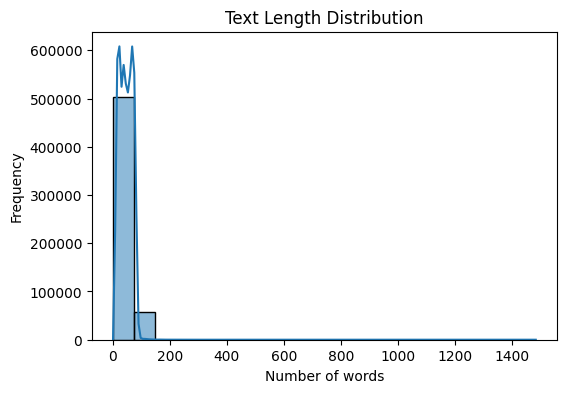

In [10]:
#Add a text length column to decide the max_length for tokenization
df_train['text_length']=df_train['content'].apply(lambda x:len(x.split()))

#Plot Distribution
plt.figure(figsize=(6,4))
sns.histplot(df_train['text_length'],bins=20,kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

In [11]:
#Show descriptive stats
print("Text length stats:")
print(df_train['text_length'].describe())

Text length stats:
count    560000.000000
mean         46.133234
std          22.469181
min           1.000000
25%          27.000000
50%          46.000000
75%          65.000000
max        1484.000000
Name: text_length, dtype: float64


In [12]:
#Check for duplicates

#convert the dataset['train'] to pandas for easy analysis
df=dataset['train'].to_pandas()

exact_duplicates=df.duplicated(subset='content',keep=False)
num_exact_duplicates=exact_duplicates.sum()

print("Number of exact duplicate entries:", num_exact_duplicates)

Number of exact duplicate entries: 216


Tokenizer setup

In [13]:
#Choose the model and load the tokenizer
from transformers import AutoTokenizer

model_name='bert-base-uncased'
tokenizer=AutoTokenizer.from_pretrained(model_name)

In [14]:
#Define tokenization function
def tokenize_batch(batch):
    return tokenizer(batch['content'],padding='max_length',truncation=True,max_length=128)

In [15]:
#Number of classes
num_classes=dataset['train'].features['label'].num_classes
per_class=20000//num_classes

In [16]:
#Stratified sampling
train_dataset=dataset['train']
indices=[]
labels=np.array(train_dataset["label"])
rng=np.random.default_rng(42)

for c in range(num_classes):
    class_indices=np.where(labels==c)[0]
    chosen=rng.choice(class_indices,size=per_class,replace=False)
    indices.extend(chosen.tolist())

balanced_train_dataset=train_dataset.select(sorted(indices))

print("Original train size:",len(train_dataset))
print("Balanced subset size:",len(balanced_train_dataset))
print("Samples per class:",per_class)

Original train size: 560000
Balanced subset size: 19992
Samples per class: 1428


In [26]:
#Apply tokenization to dataset
tokenized_train=balanced_train_dataset.map(tokenize_batch,batched=True)
tokenized_test=dataset['test'].map(tokenize_batch,batched=True)


Map: 100%|██████████| 19992/19992 [00:05<00:00, 3586.86 examples/s]


In [27]:
#remove original columns
tokenized_train=tokenized_train.remove_columns(['title','content'])
tokenized_train=tokenized_train.rename_column('label','labels')
tokenized_train.set_format('torch')

Model Setup and Training Loop

In [28]:
#Load the pretrained model
from transformers import AutoModelForSequenceClassification

num_labels=14

model=AutoModelForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
#Defining evaluation metrics
import numpy as np
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits,labels=eval_pred
    preds=np.argmax(logits,axis=-1)

    acc=accuracy_score(labels,preds)
    pre,rec,f1,_=precision_recall_fscore_support(labels,preds,average='macro')
    pre_w,rec_w,f1_w,_=precision_recall_fscore_support(labels,preds,average='weighted')

    return {
        'accuracy':acc,
        'precision_macro':pre,
        'recall_macro':rec,
        'f1_macro':f1,
        'f1_weighted':f1_w,
    }

In [36]:
#training arguments, hyperparameters for training
from transformers import TrainingArguments

training_args =TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch', #evaluate after each epoch
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
)

In [37]:
from transformers import Trainer

trainer= Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

C:\Users\DELL\AppData\Local\Temp\ipykernel_5548\1903471869.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer= Trainer(


In [38]:
#Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,F1 Weighted
1,0.062100,0.052972,0.989757,0.989773,0.989757,0.989751,0.989751
2,0.024400,0.055213,0.990271,0.990314,0.990271,0.990276,0.990276
3,0.014400,0.052777,0.990900,0.990922,0.990900,0.990907,0.990907


d:\DataScience\ProjectsPractice\venv\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\DataScience\ProjectsPractice\venv\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=3750, training_loss=0.07304966169993082, metrics={'train_runtime': 91844.7993, 'train_samples_per_second': 0.653, 'train_steps_per_second': 0.041, 'total_flos': 3945512220217344.0, 'train_loss': 0.07304966169993082, 'epoch': 3.0})

In [40]:
#Evaluate the model
import os, json

SAVE_DIR = "./dbpedia_bert_model_20k_cpu"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1) Save model + tokenizer
trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

# (optional) persist label maps if you have CLASS_NAMES
try:
    id2label = {i: name for i, name in enumerate(CLASS_NAMES)}
    label2id = {v: k for k, v in id2label.items()}
    trainer.model.config.id2label = id2label
    trainer.model.config.label2id  = label2id
    trainer.model.config.save_pretrained(SAVE_DIR)
except NameError:
    pass

# 2) Final evaluation
eval_metrics = trainer.evaluate()
with open(os.path.join(SAVE_DIR, "eval_metrics.json"), "w") as f:
    json.dump(eval_metrics, f, indent=2)

# 3) Save trainer state & log history (version-safe)
state_path = os.path.join(SAVE_DIR, "trainer_state.json")
try:
    trainer.state.save_to_json(state_path)          # preferred if available
except AttributeError:
    with open(state_path, "w") as f:
        json.dump(trainer.state.to_dict(), f, indent=2)

with open(os.path.join(SAVE_DIR, "log_history.json"), "w") as f:
    json.dump(trainer.state.log_history, f, indent=2)

print(f"✅ Saved everything to: {SAVE_DIR}")

d:\DataScience\ProjectsPractice\venv\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ Saved everything to: ./dbpedia_bert_model_20k_cpu


In [9]:
#Load the best model (optional)
from transformers import BertForSequenceClassification, BertTokenizer

model_path="./dbpedia_bert_model_20k_cpu"
model=BertForSequenceClassification.from_pretrained(model_path)
tokenizer=BertTokenizer.from_pretrained(model_path)

In [12]:
#Kernel restarted, load and tokenize test set
from datasets import load_dataset

dataset=load_dataset("dbpedia_14")
test_texts=list(dataset['test']['content'])
test_labels=dataset['test']['label']

tokenizer=BertTokenizer.from_pretrained(model_path)
tokenized_test=tokenizer(test_texts,truncation=True,padding=True, return_tensors='pt')

In [14]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
from tqdm import tqdm

# Tokenize again with return_tensors="pt" and convert labels to tensor
inputs = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt")
labels = torch.tensor(test_labels)

# Create TensorDataset and DataLoader
dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
loader = DataLoader(dataset, batch_size=32)  # Use batch size based on your RAM

model.eval()
all_preds = []

with torch.no_grad():
    for batch in tqdm(loader):
        input_ids, attention_mask, _ = batch
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.tolist())


100%|██████████| 2188/2188 [16:16:04<00:00, 26.77s/it]  


              precision    recall  f1-score   support

           0     0.9700    0.9776    0.9738      5000
           1     0.9927    0.9830    0.9878      5000
           2     0.9836    0.9858    0.9847      5000
           3     0.9970    0.9940    0.9955      5000
           4     0.9839    0.9888    0.9863      5000
           5     0.9948    0.9948    0.9948      5000
           6     0.9821    0.9856    0.9838      5000
           7     0.9964    0.9940    0.9952      5000
           8     0.9970    0.9988    0.9979      5000
           9     0.9970    0.9984    0.9977      5000
          10     0.9980    0.9946    0.9963      5000
          11     0.9948    0.9952    0.9950      5000
          12     0.9932    0.9920    0.9926      5000
          13     0.9926    0.9902    0.9914      5000

    accuracy                         0.9909     70000
   macro avg     0.9909    0.9909    0.9909     70000
weighted avg     0.9909    0.9909    0.9909     70000



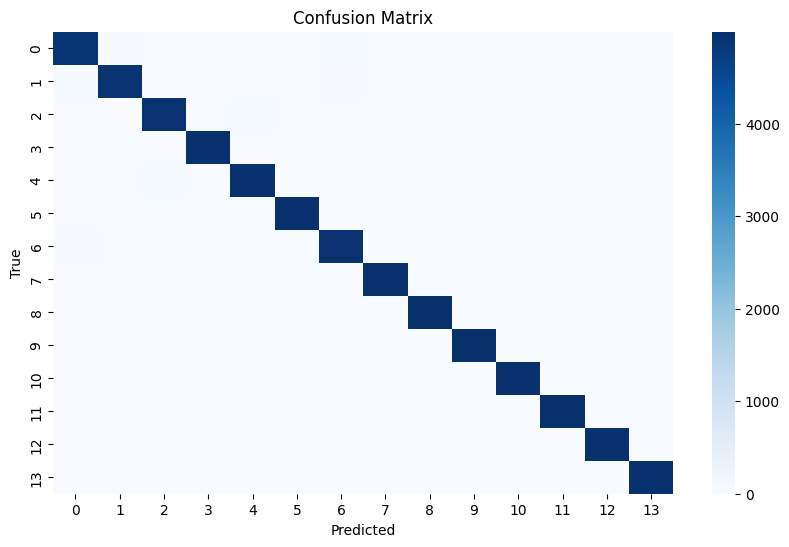

In [15]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Predict on test split
#predictions=trainer.predict(tokenized_dataset['test'])
#y_true=predictions.label_ids
#y_pred=np.argmax(predictions.predictions,axis=1)

#Classification report
print(classification_report(test_labels,all_preds,digits=4))

#Confusion Matrix
cm=confusion_matrix(test_labels,all_preds)
plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

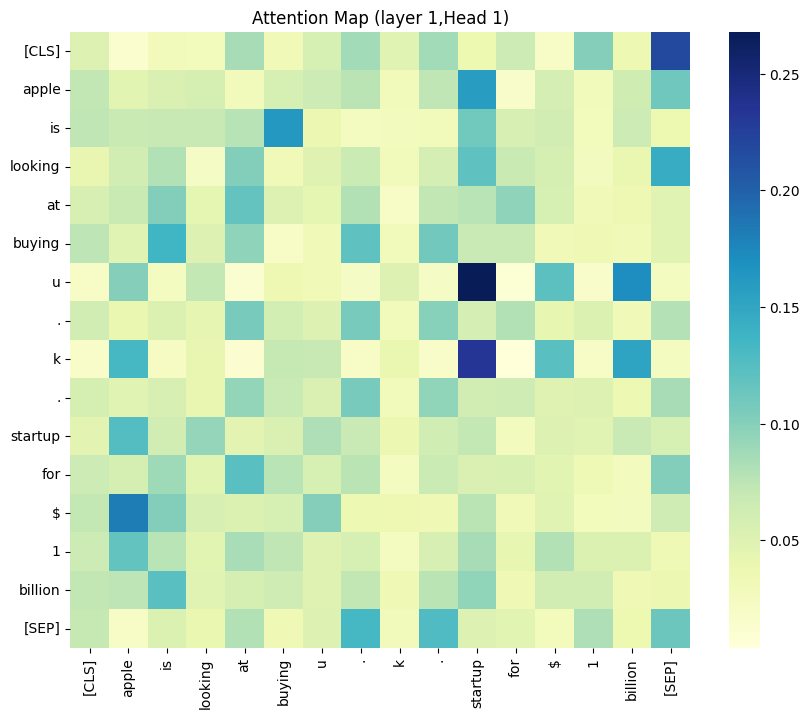

In [18]:
#Attention Visualize
#Visualize attention for single text
model.eval()

def visualize_attention(text,model,tokenizer,layer=0,head=0):
    #tokenize input
    inputs=tokenizer(text,return_tensors="pt",truncation=True,max_length=128)

    #forward pass with attention outputs
    with torch.no_grad():
        outputs=model(**inputs,output_attentions=True)

    #extract attention from the specificied layer and head
    attention=outputs.attentions[layer][0,head].detach().numpy()

    tokens=tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    #plot attention as heat map
    plt.figure(figsize=(10,8))
    sns.heatmap(attention,xticklabels=tokens,yticklabels=tokens,cmap='YlGnBu')
    plt.title(f"Attention Map (layer {layer+1},Head {head+1})")
    plt.show()
text="Apple is looking at buying U.K. startup for $1 billion"
#Example
visualize_attention(text,model,tokenizer)
    

In [ ]:
#SHAP Explainability (SHapley Additive exPlanations)

In [20]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [35]:
import shap

from transformers import TextClassificationPipeline

#create pipeline
pipe=TextClassificationPipeline(model=model,tokenizer=tokenizer,return_all_score=True)

#create shap explainer using pipeline directly
explainer=shap.Explainer(pipe)

#single example
sample_text="Apple is looking at buying U.K. startup for $1 billion"
shap_values=explainer([sample_text])

#plot
shap.plots.text(shap_values[0])


Device set to use cpu
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Ke

In [33]:
#Explain multiple samples
texts=["Apple is looking at buying U.K. startup for $1 billion",
       "The president gave a sppech about international policy"]

shap_values=explainer(texts)
shap.plots.text(shap_values)

Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'return_all_score': True} not recognized.
Keyword arguments {'retu